In [12]:
import torch
import matplotlib.pyplot as plt

class GradientFlowPlotter:
    def __init__(self, model, plot_func):
        self.model = model
        self.plot_func = plot_func  # Function to create the plot

    def plot_grad_flow(self, named_parameters):
        all_grads = []
        layers = []

        for name, parameter in named_parameters:
            if parameter.grad is not None:  # Check if the gradient exists
                layers.append(name)
                grad_mean = parameter.grad.abs().mean().detach().cpu().numpy()
                all_grads.append(grad_mean)
            else:
                layers.append(name)
                all_grads.append(0.0)  # Use 0 if no gradient is available

        return self.plot_func(all_grads, layers)

    def plot_all_epochs(self, model_path_format, num_epochs, dummy_input):
        for epoch in range(1, num_epochs + 1):
            # Load the model state
            model_path = model_path_format.format(epoch)
            self.model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            self.model.eval()

            # Perform a forward and backward pass with dummy input
            dummy_output = self.model(dummy_input)
            loss = dummy_output.mean()  # Simplified dummy loss for demonstration
            self.model.zero_grad()
            loss.backward()

            # Plot gradient flow for this epoch
            print(f"Plotting gradient flow for epoch {epoch}")
            plt = self.plot_grad_flow(self.model.named_parameters())
            plt.show()  # Display the plot for the current epoch

In [ ]:
def plot_func_def(all_grads, layers):
    
    
    """
    Plot function definition to plot the average gradient with respect to the number of layers in the given model
    :param all_grads: Gradients wrt weights for each layer in the model.
    :param layers: Layer names corresponding to the model parameters
    :return: plot for gradient flow
    """
    plt.plot(all_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(all_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(all_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(all_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.tight_layout()
    
    return plt
    

def plot_grad_flow(named_parameters):
    """
    The function is being called in Line 298 of this file. 
    Receives the parameters of the model being trained. Returns plot of gradient flow for the given model parameters.
    
    """
    all_grads = []
    layers = []
    
    """
    Complete the code in the block below to collect absolute mean of the gradients for each layer in all_grads with the             layer names in layers.
    """
    ########################################
    #TODO write your code here
    
    ########################################
    
    for layer, parameter in named_parameters:
        if "bias" in layer:
            continue
        layer_name = layer.replace('.weight', '').replace('.bias', '').replace("layer_dict.", "").replace(".", "_")

        mean_grad = parameter.grad.abs().mean().item()
        layers.append(layer_name)
        all_grads.append(mean_grad)
    
    plt = plot_func_def(all_grads, layers)
    return plt
# plot_grad_flow(model.named_parameters())

Building basic block of ConvolutionalNetwork using input shape (100, 3, 32, 32)
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 32, 32])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 16, 16])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 8, 8])
torch.Size([100, 32, 4, 4])
shape before final linear layer torch.Size([100, 32, 1, 1])
Block is built, output volume is torch.Size([100, 100])


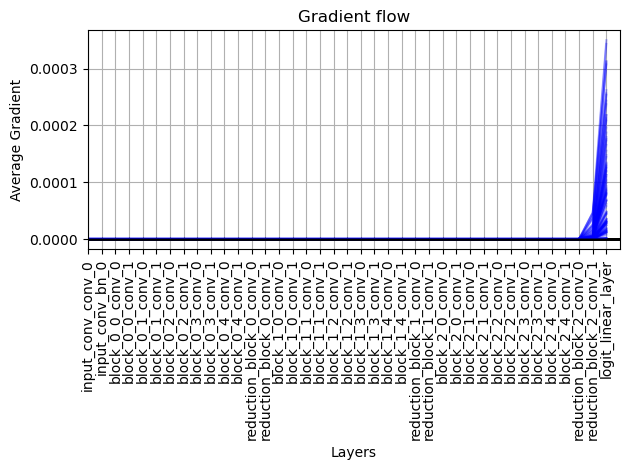

In [125]:
from pytorch_mlp_framework.model_architectures import *
# Assuming you have a PyTorch model defined as `MyModel`
model = ConvolutionalNetwork(  # initialize our network object, in this case a ConvNet
    input_shape=(100, 3, 32, 32),
    num_output_classes=100, num_filters=32, use_bias=False,
    num_blocks_per_stage=5, num_stages=3,
    processing_block_type=ConvolutionalProcessingBlock,
    dimensionality_reduction_block_type=ConvolutionalDimensionalityReductionBlock)


dummy_input = torch.randn(100, 3, 32, 32)  # Adjust to your input shape
dummy_target = torch.randint(0, 100, (100,))  # Dummy target for classification

criterion = nn.CrossEntropyLoss()

# Path format for saved models
PATH = "/Users/AlexDronov/Desktop/MSc Data Science/mlpractical/\
VGG_38_experiment/saved_models/train_model_{}"
for epoch in range(0, 100):
    checkpoint = torch.load(PATH.format(epoch), map_location=torch.device('cpu'), weights_only=False)
    state_dict = checkpoint['network']
    state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
    model.load_state_dict(state_dict)
    outputs = model(dummy_input)

    # Compute loss
    loss = criterion(outputs, dummy_target)

    # Backward pass to compute gradients
    model.zero_grad()  # Clear previous gradients
    loss.backward()

    # Plot gradient flow
    plot_grad_flow(model.named_parameters())


In [ ]:
layer_grads = {}
layers = []
for layer, parameter in model.named_parameters():
        layer_name = layer.replace('.weight', '').replace('.bias', '')# .replace("layer_dict.", "").replace(".", "_")

        mean_grad = parameter.grad.abs().mean().item()
        if layer_name not in layer_grads:
            layer_grads[layer_name] = mean_grad
        else:
            layer_grads[layer_name] = (layer_grads[layer_name] + mean_grad)/2

layers = list(layer_grads.keys())
values = list(layer_grads.values())
print(len(values))
print(len(layers))

39
39


In [121]:
for layer, parameter in model.named_parameters():
    print(layer.replace('.weight', '').replace('.bias', '').replace("layer_dict.", "").replace(".", "_"))

input_conv_conv_0
input_conv_bn_0
input_conv_bn_0
block_0_0_conv_0
block_0_0_conv_1
block_0_1_conv_0
block_0_1_conv_1
block_0_2_conv_0
block_0_2_conv_1
block_0_3_conv_0
block_0_3_conv_1
block_0_4_conv_0
block_0_4_conv_1
reduction_block_0_conv_0
reduction_block_0_conv_0
reduction_block_0_conv_1
reduction_block_0_conv_1
block_1_0_conv_0
block_1_0_conv_1
block_1_1_conv_0
block_1_1_conv_1
block_1_2_conv_0
block_1_2_conv_1
block_1_3_conv_0
block_1_3_conv_1
block_1_4_conv_0
block_1_4_conv_1
reduction_block_1_conv_0
reduction_block_1_conv_0
reduction_block_1_conv_1
reduction_block_1_conv_1
block_2_0_conv_0
block_2_0_conv_1
block_2_1_conv_0
block_2_1_conv_1
block_2_2_conv_0
block_2_2_conv_1
block_2_3_conv_0
block_2_3_conv_1
block_2_4_conv_0
block_2_4_conv_1
reduction_block_2_conv_0
reduction_block_2_conv_0
reduction_block_2_conv_1
reduction_block_2_conv_1
logit_linear_layer
logit_linear_layer
